In [1]:
# SPARK DATA LOADING & PATH VERIFICATION
# =============================================
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

# Initialize Spark with optimized configuration
spark = SparkSession.builder \
    .appName("ASVspoof_Loader") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Dataset schema for protocol files
protocol_schema = StructType([
    StructField("speaker_id", StringType()),
    StructField("audio_id", StringType()),
    StructField("system_id", StringType()),
    StructField("attack_id", StringType()),
    StructField("label", StringType())
])

# Path configuration
DATASET_ROOT = "/kaggle/input/asvpoof-2019-dataset/LA"
PATHS = {
    "train_protocol": os.path.join(DATASET_ROOT, "LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"),
    "train_audio": os.path.join(DATASET_ROOT, "LA/ASVspoof2019_LA_train/flac"),
    "dev_protocol": os.path.join(DATASET_ROOT, "LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"),
    "dev_audio": os.path.join(DATASET_ROOT, "LA/ASVspoof2019_LA_dev/flac")
}
# Load protocol data with Spark
try:
    protocol_df = spark.read.csv(
        PATHS["train_protocol"],
        schema=protocol_schema,
        sep=" ",
        nullValue="-"
    )
    print("\nProtocol data loaded successfully. Sample:")
    protocol_df.show(5, vertical=True)
except Exception as e:
    print(f"\n⚠️ Failed to load protocol data: {str(e)}")
    spark.stop()
    raise

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/24 11:34:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



Protocol data loaded successfully. Sample:


-RECORD 0------------------
 speaker_id | LA_0079      
 audio_id   | LA_T_1138215 
 system_id  | NULL         
 attack_id  | NULL         
 label      | bonafide     
-RECORD 1------------------
 speaker_id | LA_0079      
 audio_id   | LA_T_1271820 
 system_id  | NULL         
 attack_id  | NULL         
 label      | bonafide     
-RECORD 2------------------
 speaker_id | LA_0079      
 audio_id   | LA_T_1272637 
 system_id  | NULL         
 attack_id  | NULL         
 label      | bonafide     
-RECORD 3------------------
 speaker_id | LA_0079      
 audio_id   | LA_T_1276960 
 system_id  | NULL         
 attack_id  | NULL         
 label      | bonafide     
-RECORD 4------------------
 speaker_id | LA_0079      
 audio_id   | LA_T_1341447 
 system_id  | NULL         
 attack_id  | NULL         
 label      | bonafide     
only showing top 5 rows



/tmp/ipykernel_48/2242744111.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(PROTOCOL_PATH,


Successfully loaded 25380 samples


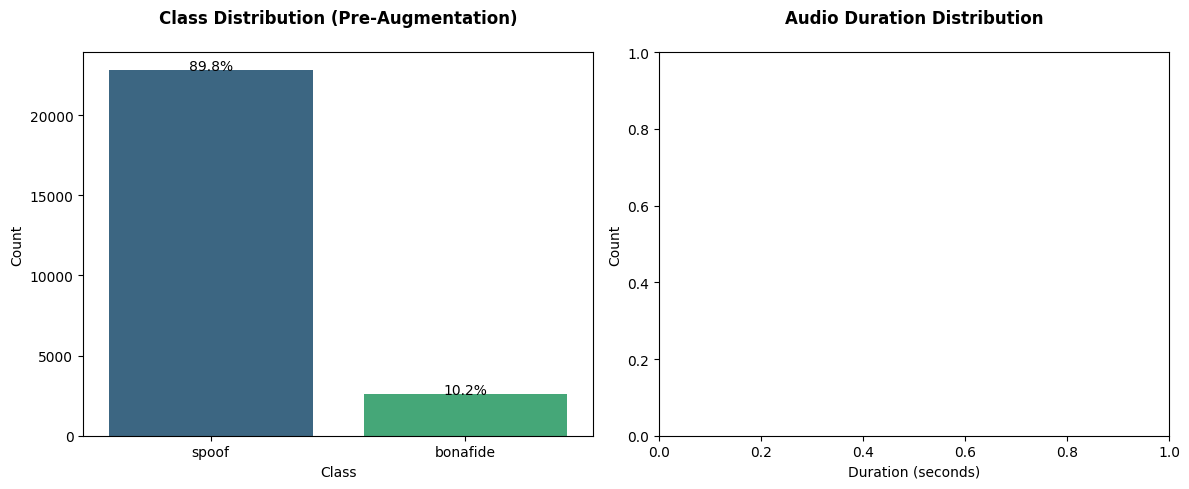


CLASS DISTRIBUTION SUMMARY


,Count,Percentage
label,,
spoof,22800,0.898345
bonafide,2580,0.101655


In [2]:
# Cell 2: Load Protocol & Pre-Augmentation Visualization
# =============================================
# PROTOCOL LOADING & PRE-AUGMENTATION ANALYSIS
# =============================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Load protocol data with robust error handling
try:
    PROTOCOL_PATH = PATHS["train_protocol"]  # From Cell 1
    df = pd.read_csv(PROTOCOL_PATH, 
                    delim_whitespace=True, 
                    header=None,
                    names=["speaker_id", "audio_id", "system_id", "attack_id", "label"])
    
    # Clean data
    df = df[df['audio_id'] != '-'].copy()
    print(f"Successfully loaded {len(df)} samples")
    
except Exception as e:
    print(f" Protocol loading failed: {str(e)}")
    raise

# Enhanced visualization
plt.figure(figsize=(12, 5))

# Plot 1: Class Distribution
plt.subplot(1, 2, 1)
ax = sns.countplot(data=df, x='label', palette='viridis', order=df['label'].value_counts().index)
plt.title('Class Distribution (Pre-Augmentation)\n', fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')

# Add percentage annotations
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3,
            f'{height/total:.1%}',
            ha='center', fontsize=10)

# Plot 2: Sample Duration Distribution
plt.subplot(1, 2, 2)
sample_durations = []
for audio_id in df['audio_id'].sample(100, random_state=42):  # Check 100 random files
    try:
        audio, sr = librosa.load(f"{PATHS['train_audio']}/{audio_id}.flac", sr=None)
        sample_durations.append(len(audio)/sr)
    except:
        continue
        
sns.histplot(sample_durations, bins=20, kde=True, color='teal')
plt.title('Audio Duration Distribution\n', fontweight='bold')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Display class statistics
print("\n" + "="*50)
print("CLASS DISTRIBUTION SUMMARY")
print("="*50)
display(df['label'].value_counts().to_frame('Count').assign(Percentage=lambda x: x/x.sum()))


✅ Successfully loaded 25380 samples

📉 Class distribution BEFORE undersampling:


/tmp/ipykernel_48/3444537066.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(PROTOCOL_PATH,


,Count,Percentage
label,,
spoof,22800,0.898345
bonafide,2580,0.101655


/tmp/ipykernel_48/3444537066.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))



🔧 Undersampling majority classes to 2580 samples each
✅ After undersampling: 5160 samples (2 classes)


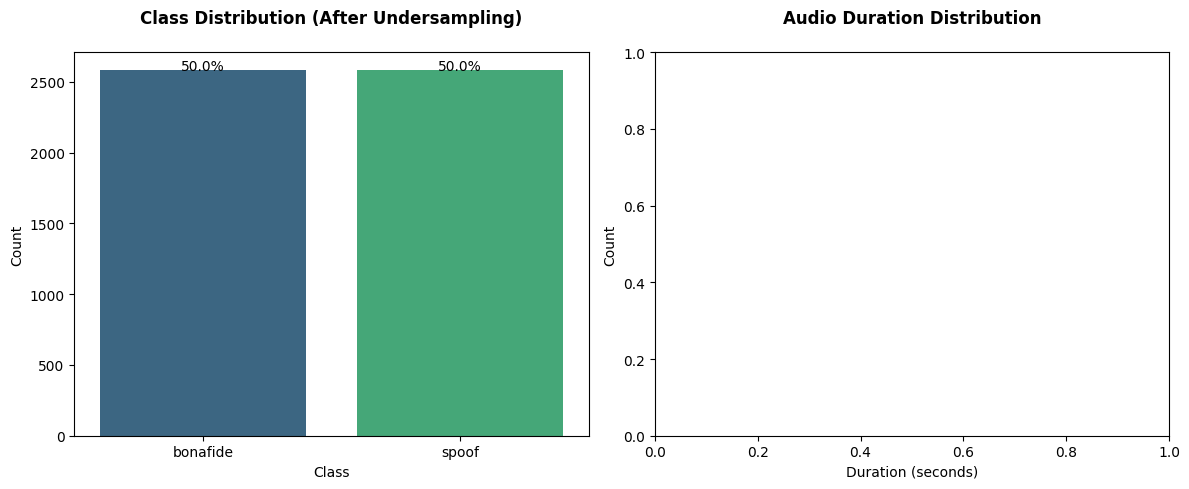


CLASS DISTRIBUTION SUMMARY (After Undersampling)


,Count,Percentage
label,,
bonafide,2580,0.5
spoof,2580,0.5


In [3]:
# Cell 2: Load Protocol & Pre-Augmentation Visualization
# =============================================
# PROTOCOL LOADING & PRE-AUGMENTATION ANALYSIS
# =============================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Load protocol data with robust error handling
try:
    PROTOCOL_PATH = PATHS["train_protocol"]  # From Cell 1
    df = pd.read_csv(PROTOCOL_PATH,
                    delim_whitespace=True,
                    header=None,
                    names=["speaker_id", "audio_id", "system_id", "attack_id", "label"])

    # Clean data
    df = df[df['audio_id'] != '-'].copy()
    print(f"✅ Successfully loaded {len(df)} samples")

except Exception as e:
    print(f"❌ Protocol loading failed: {str(e)}")
    raise



print("\n📉 Class distribution BEFORE undersampling:")
before_stats = df['label'].value_counts().to_frame('Count')
before_stats = before_stats.assign(Percentage=lambda x: x/x.sum())
display(before_stats)


class_counts = df['label'].value_counts()
min_count = class_counts.min()
print(f"\n🔧 Undersampling majority classes to {min_count} samples each")


df_balanced = (
    df.groupby('label', group_keys=False)
      .apply(lambda x: x.sample(min_count, random_state=42))
      .reset_index(drop=True)
)

print(f"✅ After undersampling: {len(df_balanced)} samples "
      f"({df_balanced['label'].nunique()} classes)")


df = df_balanced
# ======================================================================


# Enhanced visualization
plt.figure(figsize=(12, 5))

# Plot 1: Class Distribution
plt.subplot(1, 2, 1)
ax = sns.countplot(data=df, x='label',
                   palette='viridis',
                   order=df['label'].value_counts().index)
plt.title('Class Distribution (After Undersampling)\n', fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')

# Add percentage annotations
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3,
            f'{height/total:.1%}',
            ha='center', fontsize=10)

# Plot 2: Sample Duration Distribution
plt.subplot(1, 2, 2)
sample_durations = []
for audio_id in df['audio_id'].sample(100, random_state=42):  # Check 100 random files
    try:
        audio, sr = librosa.load(f"{PATHS['train_audio']}/{audio_id}.flac", sr=None)
        sample_durations.append(len(audio)/sr)
    except:
        continue

sns.histplot(sample_durations, bins=20, kde=True, color='teal')
plt.title('Audio Duration Distribution\n', fontweight='bold')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Display class statistics (SAU undersampling)
print("\n" + "="*50)
print("CLASS DISTRIBUTION SUMMARY (After Undersampling)")
print("="*50)
display(df['label'].value_counts().to_frame('Count').assign(Percentage=lambda x: x/x.sum()))


In [4]:
# Cell 3: Feature Extraction (Log-Mel Spectrograms for 2D CNN)

# =============================================
# WORKING FEATURE EXTRACTION (CONFIRMED FORMAT)
# =============================================
import librosa
import numpy as np
from tqdm import tqdm
import os

# Configuration (confirmed correct)
AUDIO_DIR = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"

# 1. Feature extraction function
def extract_features(audio_path, target_frames=100, sr=16000, n_mfcc=40):
    """Extract MFCC features with fixed time dimension"""
    try:
        # Load audio (using kaiser_fast for reliable loading)
        audio, sr = librosa.load(audio_path, sr=sr, duration=4.0, res_type='kaiser_fast')
        
        # Extract MFCC with deltas
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        delta1 = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        
        # Stack features (120 x time)
        combined = np.vstack([mfcc, delta1, delta2])
        
        # Time-axis processing
        if combined.shape[1] < target_frames:
            combined = np.pad(combined, ((0,0), (0,target_frames-combined.shape[1])), 
                            mode='constant')
        else:
            combined = combined[:, :target_frames]
            
        return combined.T  # Return (time, features)
    
    except Exception as e:
        print(f"Error processing {os.path.basename(audio_path)}: {str(e)}")
        return None

# 2. Prepare paths (using confirmed LA_T_xxxxxxx format)
file_paths = [os.path.join(AUDIO_DIR, f"{aid}.flac") for aid in df['audio_id']]
labels = (df['label'] == 'bonafide').astype(int).values

# 3. Process files with progress bar
features = []
valid_labels = []

for path, label in tqdm(zip(file_paths, labels), 
                        total=len(file_paths),
                        desc="Extracting Features"):
    if os.path.exists(path):
        feat = extract_features(path)
        if feat is not None:
            features.append(feat)
            valid_labels.append(label)

# 4. Create final arrays
if features:
    X = np.array(features)[..., np.newaxis]  # (samples, 100, 120, 1)
    y = np.array(valid_labels)
    
    print("\n" + "="*50)
    print("FEATURE EXTRACTION SUCCESS")
    print("="*50)
    print(f"✅ Samples processed: {len(X)}")
    print(f"🔼 Feature shape: {X.shape}")
    print(f"🔢 Class distribution:")
    print(pd.Series(y).value_counts().to_string())
    
    # Save features
    np.save("X_features.npy", X)
    np.save("y_labels.npy", y)
else:
    print("\nERROR: No features extracted - please verify audio files")


Extracting Features: 100%|██████████| 5160/5160 [02:34<00:00, 33.38it/s]



FEATURE EXTRACTION SUCCESS
✅ Samples processed: 5160
🔼 Feature shape: (5160, 100, 120, 1)
🔢 Class distribution:
1    2580
0    2580


In [5]:
import librosa
import numpy as np

audio_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac/LA_T_1000137.flac'
audio, sr = librosa.load(audio_path, sr=16000)

# Extract MFCC and check its shape
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
print(f"MFCC shape: {mfcc.shape}")

MFCC shape: (40, 79)


2025-11-24 11:44:59.933185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763984700.202412      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763984700.272429      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Features shape: (5160, 100, 120, 1)
Labels shape: (5160,)
Class distribution: [2580 2580]

Fold 1/5 - Training


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-24 11:45:19.156408: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5989 - auc: 0.6450 - loss: 0.6614 - precision: 0.5957 - recall: 0.6598 - val_accuracy: 0.5000 - val_auc: 0.5077 - val_loss: 0.8180 - val_precision: 0.5000 - val_recall: 0.0039 - learning_rate: 1.0000e-04
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7382 - auc: 0.8021 - loss: 0.5608 - precision: 0.7198 - recall: 0.7988 - val_accuracy: 0.5213 - val_auc: 0.5598 - val_loss: 0.7323 - val_precision: 0.5550 - val_recall: 0.2151 - learning_rate: 1.0000e-04
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7766 - auc: 0.8479 - loss: 0.5077 - precision: 0.7472 - recall: 0.8326 - val_accuracy: 0.6298 - val_auc: 0.6762 - val_loss: 0.6452 - val_precision: 0.5915 - val_recall: 0.8391 - learning_rate: 1.0000e-04
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8205 - auc: 0.8819 - loss: 0.4569 - precision: 0.8019 - recall: 0.8562 - val_accuracy: 0.6851 - val_auc: 0.8327 - val_loss: 0.5936 -

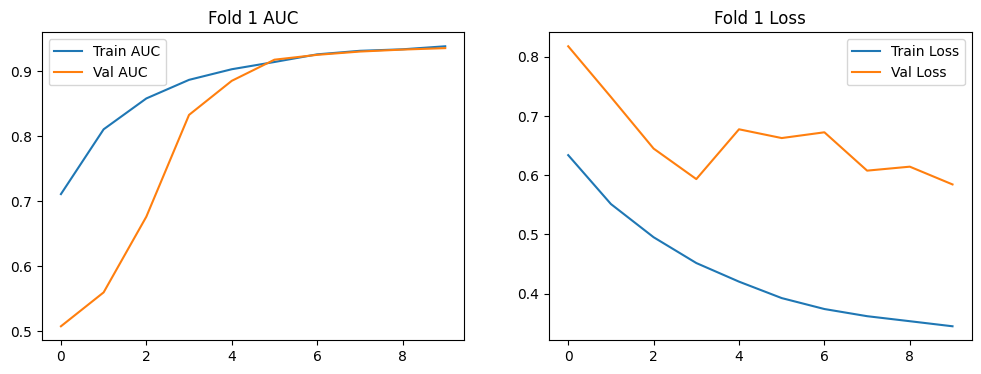


Fold 2/5 - Training


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5911 - auc: 0.6257 - loss: 0.6662 - precision: 0.5857 - recall: 0.6407 - val_accuracy: 0.5010 - val_auc: 0.7109 - val_loss: 0.6996 - val_precision: 0.5714 - val_recall: 0.0078 - learning_rate: 1.0000e-04
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7114 - auc: 0.7742 - loss: 0.5895 - precision: 0.6820 - recall: 0.7929 - val_accuracy: 0.7151 - val_auc: 0.8127 - val_loss: 0.5946 - val_precision: 0.7534 - val_recall: 0.6395 - learning_rate: 1.0000e-04
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7669 - auc: 0.8382 - loss: 0.5314 - precision: 0.7340 - recall: 0.8339 - val_accuracy: 0.7839 - val_auc: 0.9200 - val_loss: 0.5353 - val_precision: 0.6999 - val_recall: 0.9942 - learning_rate: 1.0000e-04
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8155 - auc: 0.8820 - loss: 0.4799 - precision: 0.7951 - recall: 0.8528 - val_accuracy: 0.7694 - val_auc: 0.9548 - val_loss: 0.4968 -

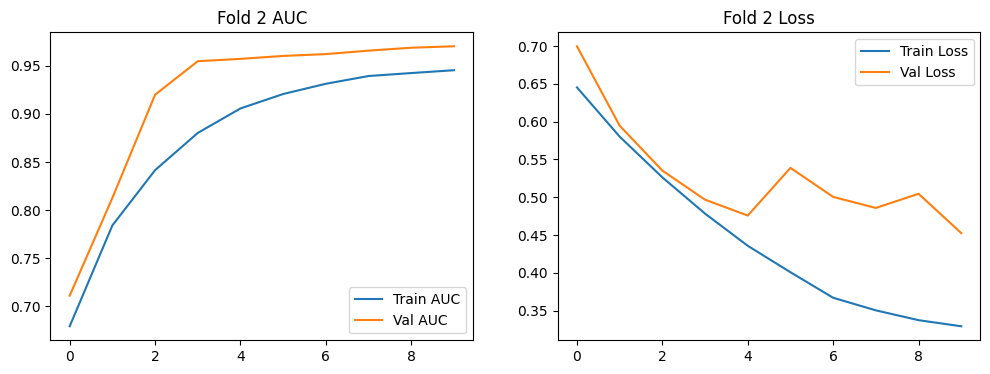


Fold 3/5 - Training


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5990 - auc: 0.6265 - loss: 0.6705 - precision: 0.5930 - recall: 0.6424 - val_accuracy: 0.4990 - val_auc: 0.5312 - val_loss: 0.8422 - val_precision: 0.3333 - val_recall: 0.0019 - learning_rate: 1.0000e-04
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7279 - auc: 0.7940 - loss: 0.5728 - precision: 0.6954 - recall: 0.7848 - val_accuracy: 0.5039 - val_auc: 0.6511 - val_loss: 0.7266 - val_precision: 0.6429 - val_recall: 0.0174 - learning_rate: 1.0000e-04
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7843 - auc: 0.8489 - loss: 0.5125 - precision: 0.7580 - recall: 0.8276 - val_accuracy: 0.6357 - val_auc: 0.7923 - val_loss: 0.6158 - val_precision: 0.8182 - val_recall: 0.3488 - learning_rate: 1.0000e-04
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8241 - auc: 0.8839 - loss: 0.4712 - precision: 0.8040 - recall: 0.8489 - val_accuracy: 0.8072 - val_auc: 0.8813 - val_loss: 0.5251 -

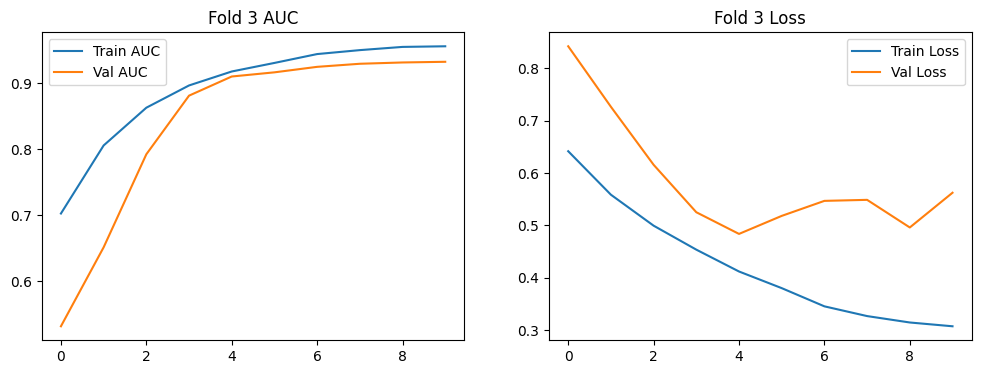


Fold 4/5 - Training


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5964 - auc: 0.6219 - loss: 0.6736 - precision: 0.5812 - recall: 0.6268 - val_accuracy: 0.5000 - val_auc: 0.5970 - val_loss: 0.8524 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7474 - auc: 0.8025 - loss: 0.5722 - precision: 0.7305 - recall: 0.7814 - val_accuracy: 0.5010 - val_auc: 0.6591 - val_loss: 0.7493 - val_precision: 0.5714 - val_recall: 0.0078 - learning_rate: 1.0000e-04
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7981 - auc: 0.8599 - loss: 0.5059 - precision: 0.7918 - recall: 0.8151 - val_accuracy: 0.7035 - val_auc: 0.8124 - val_loss: 0.5997 - val_precision: 0.7823 - val_recall: 0.5640 - learning_rate: 1.0000e-04
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8276 - auc: 0.8917 - loss: 0.4537 - precision: 0.8285 - recall: 0.8301 - val_accuracy: 0.7006 - val_auc: 0.9011 - val_loss: 

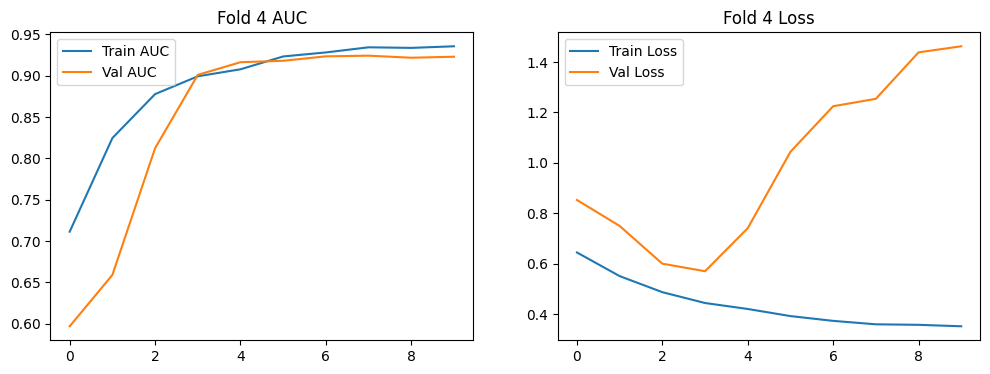


Fold 5/5 - Training


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.6030 - auc: 0.6403 - loss: 0.6637 - precision: 0.5943 - recall: 0.6392 - val_accuracy: 0.5000 - val_auc: 0.5859 - val_loss: 0.8790 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7335 - auc: 0.7962 - loss: 0.5746 - precision: 0.7242 - recall: 0.7777 - val_accuracy: 0.4922 - val_auc: 0.6422 - val_loss: 0.7092 - val_precision: 0.3750 - val_recall: 0.0233 - learning_rate: 1.0000e-04
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8043 - auc: 0.8712 - loss: 0.4995 - precision: 0.7983 - recall: 0.8178 - val_accuracy: 0.7452 - val_auc: 0.7823 - val_loss: 0.6025 - val_precision: 0.6863 - val_recall: 0.9031 - learning_rate: 1.0000e-04
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8417 - auc: 0.9010 - loss: 0.4532 - precision: 0.8391 - recall: 0.8476 - val_accuracy: 0.7141 - val_auc: 0.8380 - val_loss: 

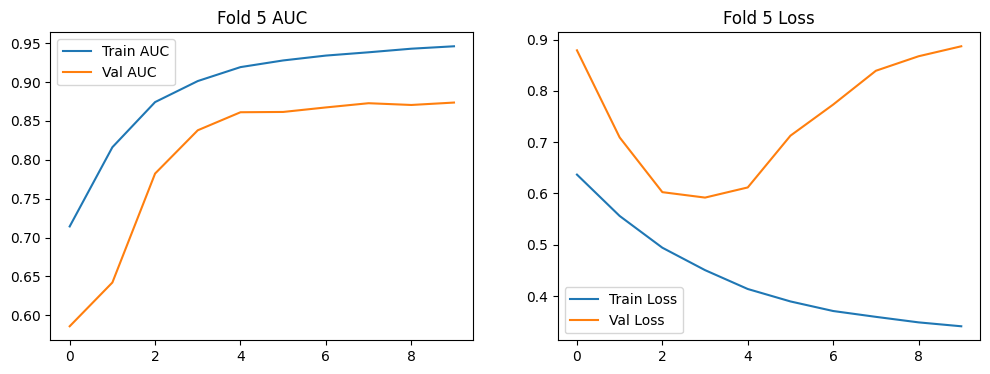


CROSS-VALIDATION RESULTS SUMMARY

Average Accuracy: 67.46% (±11.04%)
Average AUC: 92.70% (±3.11%)

Classification Report:
              precision    recall  f1-score   support

       spoof       1.00      0.18      0.31       516
    bonafide       0.55      1.00      0.71       516

    accuracy                           0.59      1032
   macro avg       0.78      0.59      0.51      1032
weighted avg       0.78      0.59      0.51      1032



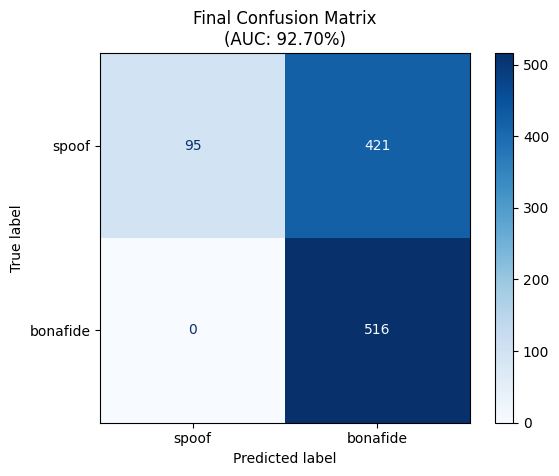

In [6]:
# IMPROVED K-FOLD VALIDATION
# =============================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Verify shapes
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

# Configure K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
results = []

for train_idx, val_idx in kf.split(X, y):
    print(f"\n{'='*40}")
    print(f"Fold {fold}/5 - Training")
    print(f"{'='*40}")
    
    # Data splitting
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Model architecture with regularization
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(100, 120, 1)),
        BatchNormalization(),
        MaxPooling2D(2),
        Dropout(0.25),
        
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2),
        Dropout(0.25),
        
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dropout(0.5),
        
        Dense(1, activation='sigmoid')
    ])
    
    # Compile with lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.AUC(name='auc'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])
    
    # Callbacks
    callbacks = [
        EarlyStopping(patience=5, monitor='val_auc', mode='max', restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6)
    ]
    
    # Training
    history = model.fit(X_train, y_train,
                       epochs=10,
                       batch_size=64,
                       validation_data=(X_val, y_val),
                       callbacks=callbacks,
                       verbose=1)
    
    # Evaluation
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    y_proba = model.predict(X_val)
    
    # Store metrics
    results.append({
        'accuracy': accuracy_score(y_val, y_pred),
        'auc': roc_auc_score(y_val, y_proba),
        'cm': confusion_matrix(y_val, y_pred),
        'report': classification_report(y_val, y_pred, target_names=['spoof', 'bonafide'], output_dict=True)
    })
    
    # Plot training history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title(f'Fold {fold} AUC')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} Loss')
    plt.legend()
    plt.show()
    
    fold += 1

# Final evaluation
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*50)

avg_accuracy = np.mean([r['accuracy'] for r in results])
avg_auc = np.mean([r['auc'] for r in results])

print(f"\nAverage Accuracy: {avg_accuracy:.2%} (±{np.std([r['accuracy'] for r in results]):.2%})")
print(f"Average AUC: {avg_auc:.2%} (±{np.std([r['auc'] for r in results]):.2%})")

# Show detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['spoof', 'bonafide']))

# Plot confusion matrix
ConfusionMatrixDisplay(results[-1]['cm'], 
                      display_labels=['spoof', 'bonafide']).plot(cmap='Blues')
plt.title(f"Final Confusion Matrix\n(AUC: {avg_auc:.2%})")
plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step


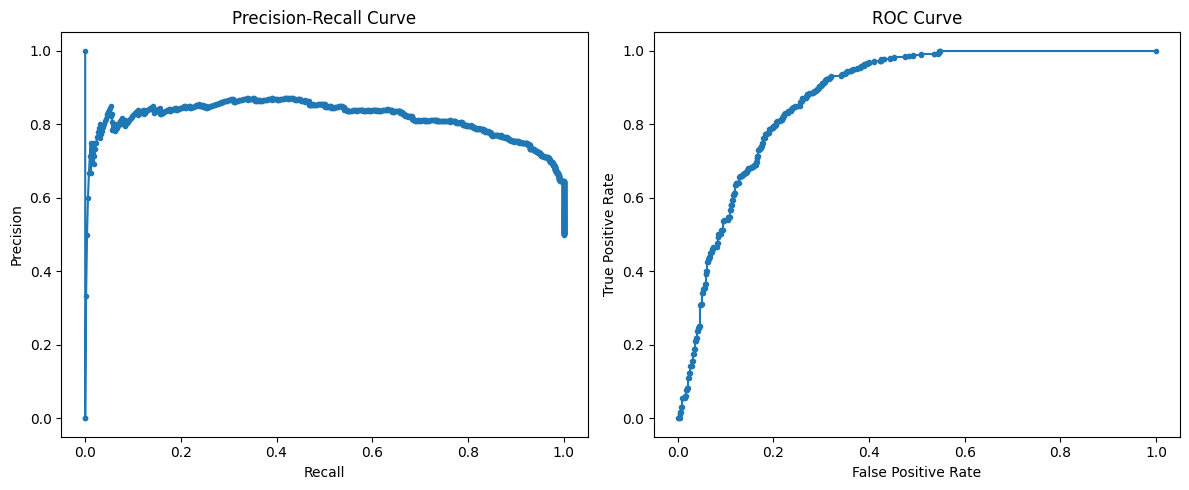

In [7]:
# Cell 6: Final Accuracy
def plot_decision_analysis(y_true, y_proba):
    """Plot precision-recall and ROC curves"""
    from sklearn.metrics import precision_recall_curve, roc_curve
    
    plt.figure(figsize=(12, 5))
    
    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, marker='.')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    
    plt.tight_layout()
    plt.show()
# Usage:
y_proba = model.predict(X_val)
plot_decision_analysis(y_val, y_proba)

In [10]:
# Save the entire model (architecture + weights + optimizer)
save_dir="/kaggle/working/"
model.save(f"{save_dir}/audio_classification.keras")  # .keras format recommended
print(f"Model saved to {save_dir}/audio_classification.keras")

Model saved to /kaggle/working//audio_classification.keras


/tmp/ipykernel_48/2594664995.py:82: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(protocol_path, delim_whitespace=True, header=None)


Extracting 71237 eval samples using threads...


Extraction: 100%|██████████| 71237/71237 [36:47<00:00, 32.27it/s]  


Done: extracted 71237 samples.
Final shapes: (71237, 100, 120, 1) (71237,)
Model loaded successfully.
Running predictions...
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 793s 711ms/step

 FINAL EVALUATION RESULTS
AUC: 0.9012
EER: 0.1797

Classification Report:
              precision    recall  f1-score   support

       Spoof       1.00      0.17      0.28     63882
    Bonafide       0.12      1.00      0.22      7355

    accuracy                           0.25     71237
   macro avg       0.56      0.58      0.25     71237
weighted avg       0.91      0.25      0.28     71237



<Figure size 600x500 with 0 Axes>

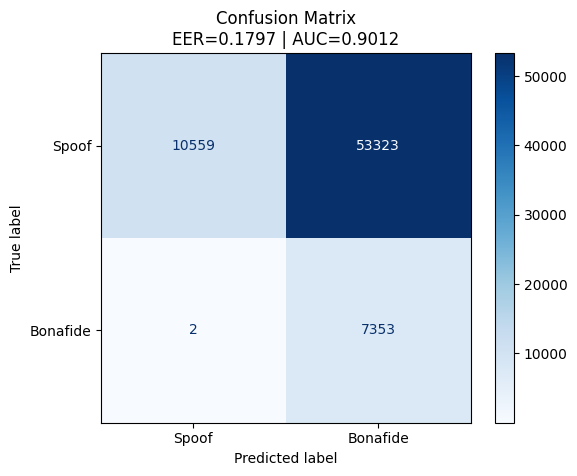

In [18]:
import numpy as np
import tensorflow as tf
import os
import librosa
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# ==============================================================================
# 1. FIXED CONFIG (PATHS CORRECT FOR KAGGLE)
# ==============================================================================

DATASET_ROOT = "/kaggle/input/asvpoof-2019-dataset/LA/LA"

EVAL_PROTOCOL_PATH = f"{DATASET_ROOT}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
EVAL_AUDIO_DIR = f"{DATASET_ROOT}/ASVspoof2019_LA_eval/flac"

MODEL_PATH = "/kaggle/working/audio_classification.keras"

# Feature extraction settings
SAMPLE_RATE = 16000
N_MFCC = 40
N_FEATURES = 120  # 40 MFCC + 40 delta + 40 delta2
TARGET_FRAMES = 100
INPUT_SHAPE = (TARGET_FRAMES, N_FEATURES, 1)


# ==============================================================================
# 2. FEATURE EXTRACTION
# ==============================================================================

def extract_features(audio_path, target_frames=TARGET_FRAMES, sr=SAMPLE_RATE):
    """Extract MFCC + deltas, pad/crop, return (time, features, 1)."""

    try:
        audio, sr = librosa.load(audio_path, sr=sr, duration=4.0, res_type="kaiser_fast")

        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        d1 = librosa.feature.delta(mfcc)
        d2 = librosa.feature.delta(mfcc, order=2)

        combined = np.vstack([mfcc, d1, d2])

        # Pad/crop
        if combined.shape[1] < target_frames:
            combined = np.pad(combined,
                              ((0, 0), (0, target_frames - combined.shape[1])),
                              mode="constant")
        else:
            combined = combined[:, :target_frames]

        return combined.T[..., np.newaxis]

    except Exception:
        return None


def process_single_file(row):
    """Extract feature + label from one protocol row."""
    filename = row[1]
    label = row[4]

    audio_path = os.path.join(EVAL_AUDIO_DIR, filename + ".flac")
    feature = extract_features(audio_path)

    if feature is None:
        return None, None

    label = 1 if label.lower() == "bonafide" else 0
    return feature, label


# ==============================================================================
# 3. LOAD EVAL DATA (KAGGLE SAFE USING THREADS)
# ==============================================================================

def load_eval_data_threaded(protocol_path, max_workers=8):
    df = pd.read_csv(protocol_path, delim_whitespace=True, header=None)
    rows = df.values.tolist()

    X_list = []
    y_list = []

    print(f"Extracting {len(rows)} eval samples using threads...")

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_single_file, r) for r in rows]

        for f in tqdm(as_completed(futures), total=len(futures), desc="Extraction"):
            feat, lab = f.result()
            if feat is not None:
                X_list.append(feat)
                y_list.append(lab)

    print(f"Done: extracted {len(X_list)} samples.")

    return np.array(X_list, dtype="float32"), np.array(y_list, dtype=int)


# ==============================================================================
# 4. MAIN EVALUATION LOGIC
# ==============================================================================

X_eval, y_eval_true = load_eval_data_threaded(EVAL_PROTOCOL_PATH)

print("Final shapes:", X_eval.shape, y_eval_true.shape)

# Load model
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully.")

# Predict
print("Running predictions...")
y_proba = model.predict(X_eval, batch_size=64, verbose=1)
y_pred = (y_proba > 0.5).astype(int)

# Metrics
auc = roc_auc_score(y_eval_true, y_proba)

fpr, tpr, _ = roc_curve(y_eval_true, y_proba)
eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

print("\n==============================")
print(" FINAL EVALUATION RESULTS")
print("==============================")
print(f"AUC: {auc:.4f}")
print(f"EER: {eer:.4f}")

print("\nClassification Report:")
print(classification_report(y_eval_true, y_pred, target_names=["Spoof", "Bonafide"]))

cm = confusion_matrix(y_eval_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Spoof', 'Bonafide'])

plt.figure(figsize=(6,5))
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix\nEER={eer:.4f} | AUC={auc:.4f}")
plt.show()
